For this code, need to use python 3 kernel and not LELEC210X kernel!

https://www.tensorflow.org/tutorials/audio/simple_audio
https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb
https://nmbu.brage.unit.no/nmbu-xmlui/bitstream/handle/11250/2611624/report-print1.pdf?sequence=3&isAllowed=y


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
from typing import List, Tuple
import glob

from classification.datasets import Dataset

from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

2024-04-23 15:50:32.858517: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:50:32.899796: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 15:50:32.900418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 15:50:33.699160: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#!pip install --upgrade pip # update pip if needed

In [4]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [5]:
#!pip list

In [6]:
model_dir = "../goldenProject/python/modelCNN/"
fv_dir = "../goldenProject/python/bigbigbigDataset/"
fm_dir = "data/fm_1000/"

<font size=5 color=#009999> 1. Our dataset </font> <br>

<font size=4 color=#009999> 1.1 Build matrix of fv </font> <br>

In [7]:
def get_cls_from_path(file):
    return file.stem.split("_", maxsplit=1)[0]


format = "pickle"
classnames = ['birds','chainsaw','fire','handsaw','helicopter']

#fv = pickle.load(open(fv_dir + filename, 'rb'))
#print(fv)
#print(fv.shape)

dic_fv = {}
for file in sorted((Path(fv_dir)).glob("**/*." + format)):
    #print(str(file))
    fv = pickle.load(open(file, 'rb'))
    fv = np.squeeze(fv)
    cls = get_cls_from_path(file)
    #print(cls)
    dic_fv.setdefault(cls, []).append(fv)
print(dic_fv)

nclass = len(dic_fv)
naudio = len(dic_fv[list(dic_fv.keys())[0]])
size = nclass * naudio

print(nclass)
print(naudio)
print(size)

# plt.figure()
# plot_specgram(fv.reshape((20, 20)).T, ax=plt.gca(), is_mel=True, title="MEL Spectrogram", xlabel="Mel vector")
# plt.show()


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
### Features vectors build matrix ###

train_pct = 0.7
print(len(dic_fv["birds"][0]))
featveclen = len(dic_fv["birds"][0]) # number of items in a feature vector
#nitems = size
nlearn = round(naudio * train_pct) # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor) #matrice avec les noms des classes x le nombre de sons (40 de base)

X = np.zeros((data_aug_factor*size, featveclen)) #nombre de sons total x taille du feature vector
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = dic_fv[classname][idx] #melspec
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
#np.save(fm_dir+"feature_matrix.npy", X)


400


In [9]:
#X = np.load(fm_dir+"feature_matrix.npy")

# "Labels"
y = class_ids_aug.copy() #noms des sons

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

print()

Shape of the feature matrix : (2000, 400)
Number of labels : 2000



<font size=4 color=#009999> 1.3 Build data and split it </font> <br>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y) # random_state=1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, stratify=y_train, random_state=1)

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

Shape of X_train:  (840, 400)
Shape of Y_train:  (840,)
Shape of X_val:  (560, 400)
Shape of Y_val:  (560,)
Shape of X_test:  (600, 400)
Shape of Y_test:  (600,)


In [16]:
# [2] (optional) Data normalization
X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_val = X_val / np.linalg.norm(X_val, axis=1, keepdims=True)
X_test = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#  reshape by N_Melvec x Melvec_length x 1
X_train = X_train.reshape(len(X_train), 20, 20, 1)
y_train = y_train.reshape(len(y_train),)

X_val = X_val.reshape(len(X_val), 20, 20, 1)
y_val = y_val.reshape(len(y_val),)

X_test = X_test.reshape(len(X_test), 20, 20, 1)
y_test = y_test.reshape(len(y_test),)

print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of Y_val: ", y_val.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of Y_test: ", y_test.shape)

Shape of X_train:  (840, 20, 20, 1)
Shape of Y_train:  (840,)
Shape of X_val:  (560, 20, 20, 1)
Shape of Y_val:  (560,)
Shape of X_test:  (600, 20, 20, 1)
Shape of Y_test:  (600,)


In [17]:
# [3] (optional) dimensionality reduction.

In [19]:
# [4] Model training and selection
input_shape = (20, 20, 1)
num_labels = 5
num_filters = 32
units = 32
drop_rate = 0.2

model = Sequential()

model.add(Conv2D(num_filters, (3,3), activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization()) # prevent overfitting
model.add(MaxPooling2D((2,2))) # activation layer, dimensionality reduction

model.add(Conv2D(num_filters, (3,3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(32, activation = 'relu'))

model.add(Dropout(drop_rate))

model.add(Dense(num_labels, activation = 'softmax'))

In [27]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NameError: name 'optimizers' is not defined

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        320       
                                                                 
 batch_normalization_1 (Bat  (None, 18, 18, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 32)          128       
 chNormalization)                                                
                                                      

In [23]:
label_encoder = LabelEncoder()

#y_train = y_train.reshape(-1,) 
print(y_train.shape)
print(y_train)
y_train_encoded = label_encoder.fit_transform(y_train) # Reshape labels to (n_samples,)
y_val_encoded = label_encoder.fit_transform(y_val) # Reshape labels to (n_samples,)
print(y_train_encoded.shape)
print(X_train.shape)

(840,)
['chainsaw' 'chainsaw' 'fire' 'handsaw' 'helicopter' 'fire' 'helicopter'
 'chainsaw' 'helicopter' 'birds' 'helicopter' 'fire' 'fire' 'chainsaw'
 'birds' 'helicopter' 'chainsaw' 'birds' 'fire' 'helicopter' 'fire'
 'handsaw' 'fire' 'fire' 'handsaw' 'birds' 'handsaw' 'birds' 'birds'
 'fire' 'chainsaw' 'handsaw' 'handsaw' 'fire' 'birds' 'chainsaw'
 'helicopter' 'fire' 'birds' 'handsaw' 'birds' 'chainsaw' 'fire'
 'helicopter' 'handsaw' 'birds' 'fire' 'chainsaw' 'chainsaw' 'fire'
 'chainsaw' 'handsaw' 'chainsaw' 'chainsaw' 'handsaw' 'handsaw' 'chainsaw'
 'handsaw' 'handsaw' 'helicopter' 'chainsaw' 'birds' 'helicopter'
 'helicopter' 'helicopter' 'birds' 'helicopter' 'chainsaw' 'birds' 'birds'
 'helicopter' 'fire' 'helicopter' 'fire' 'helicopter' 'helicopter'
 'chainsaw' 'fire' 'birds' 'handsaw' 'helicopter' 'fire' 'helicopter'
 'handsaw' 'chainsaw' 'birds' 'chainsaw' 'birds' 'birds' 'helicopter'
 'fire' 'handsaw' 'helicopter' 'fire' 'birds' 'handsaw' 'helicopter'
 'birds' 'fire' 'helic

In [24]:
epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size = 16 , validation_data=(X_val, y_val_encoded),  callbacks=[early_stopping])

Epoch 1/100
53/53 [==============================] - 1s 9ms/step - loss: 1.1222 - accuracy: 0.5940 - val_loss: 1.5973 - val_accuracy: 0.2000
Epoch 2/100
53/53 [==============================] - 0s 5ms/step - loss: 0.7981 - accuracy: 0.7071 - val_loss: 1.5834 - val_accuracy: 0.2036
Epoch 3/100
53/53 [==============================] - 0s 6ms/step - loss: 0.6010 - accuracy: 0.7869 - val_loss: 1.5562 - val_accuracy: 0.2429
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.5069 - accuracy: 0.8131 - val_loss: 1.5161 - val_accuracy: 0.2536
Epoch 5/100
53/53 [==============================] - 0s 5ms/step - loss: 0.4544 - accuracy: 0.8369 - val_loss: 1.5730 - val_accuracy: 0.2464
Epoch 6/100
53/53 [==============================] - 0s 5ms/step - loss: 0.3708 - accuracy: 0.8655 - val_loss: 1.5275 - val_accuracy: 0.3339
Epoch 7/100
53/53 [==============================] - 0s 5ms/step - loss: 0.2980 - accuracy: 0.8917 - val_loss: 1.4934 - val_accuracy: 0.2661
Epoch 8/100
5

{'loss': [1.1222018003463745, 0.7981485724449158, 0.6010085940361023, 0.5068610906600952, 0.4543992877006531, 0.370768666267395, 0.2980193793773651, 0.29851463437080383, 0.2547970414161682, 0.2404409497976303, 0.20922917127609253, 0.18241271376609802, 0.20521040260791779, 0.1731611043214798, 0.14139190316200256, 0.11599955707788467, 0.08552895486354828, 0.09476585686206818, 0.1271478235721588, 0.13006344437599182, 0.09401758015155792], 'accuracy': [0.5940476059913635, 0.7071428298950195, 0.7869047522544861, 0.813095211982727, 0.836904764175415, 0.8654761910438538, 0.8916666507720947, 0.9047619104385376, 0.9142857193946838, 0.913095235824585, 0.9321428537368774, 0.9452381134033203, 0.9321428537368774, 0.9464285969734192, 0.9488095045089722, 0.9690476059913635, 0.973809540271759, 0.9797618985176086, 0.9583333134651184, 0.9583333134651184, 0.9642857313156128], 'val_loss': [1.5972663164138794, 1.5834217071533203, 1.5561920404434204, 1.516119122505188, 1.572950005531311, 1.5275410413742065,

Text(0, 0.5, 'Accuracy [%]')

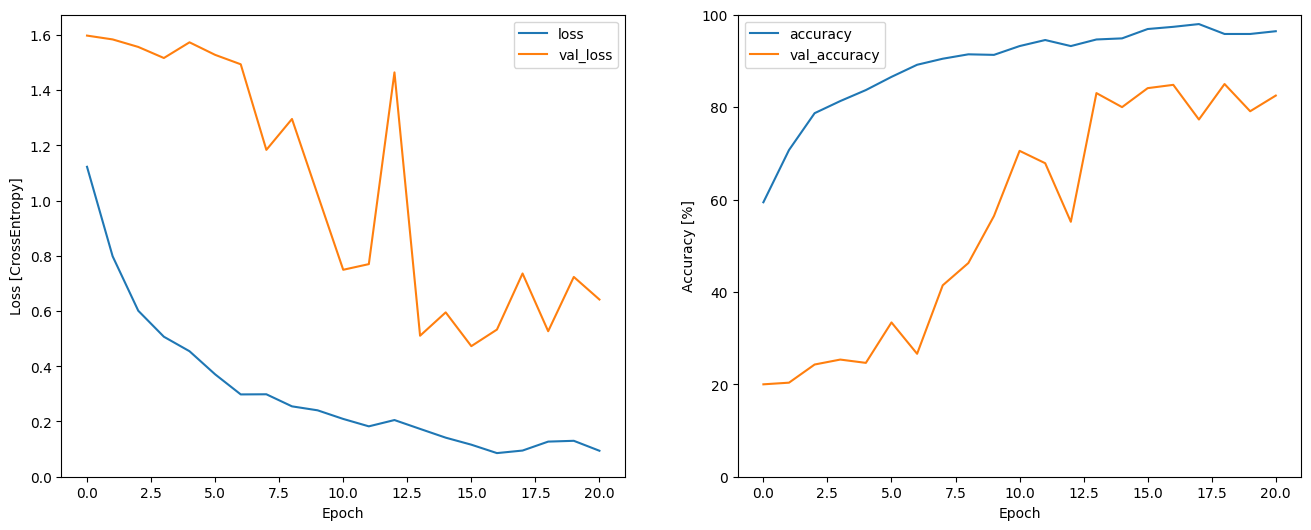

In [25]:
metrics = history.history
print(metrics)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#plt.savefig('Loss-Acc-epochs=40-batch_size=16-FV=1000.pdf')

In [32]:
y_test_encoded = label_encoder.fit_transform(y_test)

model.evaluate(X_test, y_test_encoded)

4/4 [==============================] - 0s 3ms/step - loss: 0.4070 - accuracy: 0.9280


[0.4069952964782715, 0.9279999732971191]

In [36]:
# [5] Save the trained model, eventually the pca.
filename = 'CNN.pickle'
file_label_encoder = 'label_encoder.pickle'

pickle.dump(model, open(model_dir+filename, 'wb'))
pickle.dump(model, open(model_dir+file_label_encoder, 'wb'))

In [37]:
import matplotlib.pyplot as plt
import numpy as np

"For confusion matrix plot"
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

# -----------------------------------------------------------------------------
"""
Synthesis of the functions in :

- show_confusion_matrix : plot confusion matrix.
- plot_audio : Plot an audiosignal in time and frequency
- plot_specgram : Plot a spectrogram (2D matrix)
- plot_decision_boundary : Plot decision boundary of a classifier.
"""
# -----------------------------------------------------------------------------


def show_confusion_matrix(y_predict, y_true, classnames, title="", saveFig = False, saveAs=''):
    """
    From target labels and prediction arrays, sort them appropriately and plot confusion matrix.
    The arrays can contain either ints or str quantities, as long as classnames contains all the elements present in them.
    """
    # # Reorder the prediction array
    # labels = np.zeros_like(y_predict)
    # for i in np.arange(len(classnames)):
    #     mask = [None]*len(y_predict)
    #     for j in np.arange(len(mask)):
    #         mask[j] = (y_predict[j] == classnames[i])
    #     labels[mask] = mode(y_true2[mask])[0]
    

    plt.figure(figsize=(5, 5))
    confmat = confusion_matrix(y_true, y_predict)
    heatmap(
        confmat.T,
        square=True,
        annot=True,
        fmt="d",
        cbar=False,
        xticklabels=classnames,
        yticklabels=classnames,
        ax=plt.gca(),
    )
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.title(title)

    if(saveFig):
        plt.savefig(saveAs)
    
    plt.show()
    return None

4/4 [==============================] - 0s 3ms/step
[2 3 4 4 2 0 2 4 1 3 0 3 3 1 3 1 2 4 2 1 2 3 0 1 3 3 1 3 0 2 2 4 1 4 1 4 0
 4 1 1 0 4 0 0 1 0 0 4 2 0 2 3 3 1 3 0 3 3 2 1 4 2 0 3 3 1 1 4 1 1 3 4 2 2
 3 2 4 4 3 1 1 4 0 1 3 3 0 0 2 2 3 0 3 0 1 1 0 3 0 0 1 3 1 0 2 1 1 4 1 1 3
 2 2 0 4 1 0 2 2 3 4 4 0 4 4]
['fire' 'handsaw' 'helicopter' 'helicopter' 'fire' 'birds' 'fire'
 'helicopter' 'chainsaw' 'handsaw' 'birds' 'handsaw' 'handsaw' 'chainsaw'
 'handsaw' 'chainsaw' 'fire' 'helicopter' 'fire' 'chainsaw' 'fire'
 'handsaw' 'birds' 'chainsaw' 'handsaw' 'handsaw' 'chainsaw' 'handsaw'
 'birds' 'fire' 'fire' 'helicopter' 'chainsaw' 'helicopter' 'chainsaw'
 'helicopter' 'birds' 'helicopter' 'chainsaw' 'chainsaw' 'birds'
 'helicopter' 'birds' 'birds' 'chainsaw' 'birds' 'birds' 'helicopter'
 'fire' 'birds' 'fire' 'handsaw' 'handsaw' 'chainsaw' 'handsaw' 'birds'
 'handsaw' 'handsaw' 'fire' 'chainsaw' 'helicopter' 'fire' 'birds'
 'handsaw' 'handsaw' 'chainsaw' 'chainsaw' 'helicopter' 'chainsaw'
 'ch

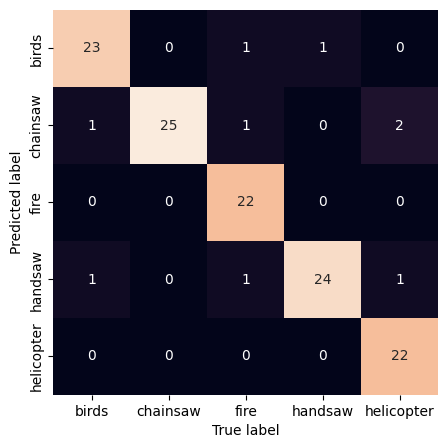

In [38]:
# [6] Evaluate the model.
prediction_CNN = model.predict(X_test) # all the proba for each class

predicted_classes = np.argmax(prediction_CNN, axis=1) # the most probable class
print(predicted_classes)
predicted_classes = label_encoder.inverse_transform(predicted_classes)
print(predicted_classes)

accuracy_CNN = accuracy(predicted_classes, y_test)

print('Accuracy of CNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_CNN))
show_confusion_matrix (predicted_classes, y_test, classnames, saveFig = False, saveAs='CM-epochs=40-batch_size=16-FV=1000.pdf')